In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Required libraries imported successfully.")

Required libraries imported successfully.


In [2]:

def clean_data(df):
    # Convert all column names to lowercase
    df.columns = df.columns.str.lower()
    # Create a new column with the mean of albedo_mod09ga and albedo_myd09ga
    # when both are available, or use the available value when only one is present.
    df['merged_albedo_mod09ga'] = df[['albedo_mod09ga', 'albedo_myd09ga']].mean(axis=1, skipna=True)
    # Move merged_albedo_mod09ga next to albedo columns of mod09ga
    albedo_columns = [col for col in df.columns if "albedo_mod09ga" in col]
    merged_index = df.columns.get_loc("merged_albedo_mod09ga")
    target_index = df.columns.get_loc(albedo_columns[-1]) + 1
    columns = list(df.columns)
    columns.insert(target_index, columns.pop(merged_index))
    df = df[columns]
    # Move 'merged_albedo_mod09ga' next to 'albedo_mod09ga'
    columns = df.columns.tolist()
    columns.remove('merged_albedo_mod09ga')
    mod09ga_index = columns.index('albedo_mod09ga') + 1
    columns.insert(mod09ga_index, 'merged_albedo_mod09ga')
    df = df[columns]
    # Create a new column 'merged_albedo_mod10a1' by merging 'albedo_mod10a1' and 'albedo_myd10a1'
    df['merged_albedo_mod10a1'] = df[['albedo_mod10a1', 'albedo_myd10a1']].mean(axis=1, skipna=True)
    # Move 'merged_albedo_mod10a1' next to 'albedo_mod10a1' in the DataFrame
    columns = list(df.columns)
    columns.remove('merged_albedo_mod10a1')
    mod10a1_index = columns.index('albedo_mod10a1')
    columns.insert(mod10a1_index + 1, 'merged_albedo_mod10a1')
    df = df[columns]
    
    # CORRECTED: Residual-based outlier detection (scientifically appropriate)
    # Calculate residuals between satellite and AWS measurements
    mod09ga_residuals = df['merged_albedo_mod09ga'] - df['albedo_aws']
    mod10a1_residuals = df['merged_albedo_mod10a1'] - df['albedo_aws']
    mcd43a3_residuals = df['albedo_mcd43a3'] - df['albedo_aws']
    
    # Calculate outlier thresholds based on residual statistics
    mod09ga_res_mean = np.nanmean(mod09ga_residuals)
    mod09ga_res_std = np.nanstd(mod09ga_residuals)
    mod10a1_res_mean = np.nanmean(mod10a1_residuals)
    mod10a1_res_std = np.nanstd(mod10a1_residuals)
    mcd43a3_res_mean = np.nanmean(mcd43a3_residuals)
    mcd43a3_res_std = np.nanstd(mcd43a3_residuals)
    
    # Flag outliers using 2.5σ threshold on residuals (recommended threshold)
    df['mod09ga_outlier'] = np.abs(mod09ga_residuals - mod09ga_res_mean) > 2.5 * mod09ga_res_std
    df['mod10a1_outlier'] = np.abs(mod10a1_residuals - mod10a1_res_mean) > 2.5 * mod10a1_res_std
    df['mcd43a3_outlier'] = np.abs(mcd43a3_residuals - mcd43a3_res_mean) > 2.5 * mcd43a3_res_std
    
    return df

def remove_outliers(df):
    """
    Create a dataset with outliers removed for clean analysis
    """
    # Remove rows where ANY product is flagged as an outlier
    clean_df = df[~(df['mod09ga_outlier'] | df['mod10a1_outlier'] | df['mcd43a3_outlier'])].copy()
    
    print(f"Original dataset: {len(df)} points")
    print(f"After removing outliers: {len(clean_df)} points")
    print(f"Outliers removed: {len(df) - len(clean_df)} points ({(len(df) - len(clean_df))/len(df)*100:.1f}%)")
    
    return clean_df

# Loaded variable 'df' from URI: d:\Documents\Projects\athabasca_analysis\data\csv\Athabasca_MultiProduct_with_AWS.csv
df = pd.read_csv(r'd:\Documents\Projects\athabasca_analysis\data\csv\Athabasca_MultiProduct_with_AWS.csv')

df_clean = clean_data(df.copy())

# Create versions with and without outliers
df_with_flags = df_clean.copy()  # Has outlier flags but keeps all data
df_no_outliers = remove_outliers(df_clean)  # Actually removes outlier rows

print("\nDataset options:")
print("- df_with_flags: All data with outlier flags (for showing outliers in plots)")
print("- df_no_outliers: Clean data with outliers removed (for clean statistics)")

df_clean.head()

Original dataset: 1298 points
After removing outliers: 1249 points
Outliers removed: 49 points (3.8%)

Dataset options:
- df_with_flags: All data with outlier flags (for showing outliers in plots)
- df_no_outliers: Clean data with outliers removed (for clean statistics)


,pixel_id,date,qa_mode,albedo_mod09ga,merged_albedo_mod09ga,albedo_myd09ga,albedo_mcd43a3,albedo_mod10a1,merged_albedo_mod10a1,albedo_myd10a1,...,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,mod09ga_outlier,mod10a1_outlier,mcd43a3_outlier
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,NaN,0.482,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,9073025950,2014-06-01,renoriginal,0.334372,0.334372,NaN,NaN,NaN,NaN,NaN,...,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414,False,False,False
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,NaN,0.29,0.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,NaN,0.486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,NaN,0.491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False


In [24]:
print(df.columns.tolist())

['pixel_id', 'date', 'qa_mode', 'albedo_MOD09GA', 'albedo_MYD09GA', 'albedo_mcd43a3', 'albedo_mod10a1', 'albedo_myd10a1', 'albedo_AWS', 'ndsi_MOD09GA', 'ndsi_MYD09GA', 'ndsi_mcd43a3', 'ndsi_mod10a1', 'ndsi_myd10a1', 'glacier_fraction_MOD09GA', 'glacier_fraction_MYD09GA', 'glacier_fraction_mcd43a3', 'glacier_fraction_mod10a1', 'glacier_fraction_myd10a1', 'solar_zenith_MOD09GA', 'solar_zenith_MYD09GA', 'solar_zenith_mcd43a3', 'solar_zenith_mod10a1', 'solar_zenith_myd10a1', 'elevation', 'slope', 'aspect', 'longitude', 'latitude', 'tile_h', 'tile_v', 'pixel_row', 'pixel_col', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']


In [ ]:
# Display first rows of the clean DataFrame (outliers removed)
df_no_outliers.head()

,pixel_id,date,qa_mode,albedo_mod09ga,merged_albedo_mod09ga,albedo_myd09ga,albedo_mcd43a3,albedo_mod10a1,merged_albedo_mod10a1,albedo_myd10a1,...,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,mod09ga_outlier,mod10a1_outlier,mcd43a3_outlier
0,9073025950,2014-06-01,qa_0_and_1,NaN,NaN,NaN,0.482,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1,9073025950,2014-06-01,renoriginal,0.334372,0.334372,NaN,NaN,NaN,NaN,NaN,...,0.3995,0.3269,0.4097,0.4115,0.0993,0.0517,0.0414,False,False,False
2,9073025950,2014-06-01,standard_qa,NaN,NaN,NaN,NaN,0.29,0.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
3,9073025950,2014-06-02,qa_0_and_1,NaN,NaN,NaN,0.486,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
4,9073025950,2014-06-03,qa_0_and_1,NaN,NaN,NaN,0.491,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1293,9075025945,2020-09-27,standard_qa,NaN,NaN,NaN,NaN,0.47,0.55,0.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1294,9075025945,2020-09-28,qa_0_and_1,NaN,NaN,NaN,0.149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1295,9075025945,2020-09-29,qa_0_and_1,NaN,NaN,NaN,0.149,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False
1296,9075025945,2020-09-30,renoriginal,0.232485,0.206787,0.181088,NaN,NaN,NaN,NaN,...,0.2363,0.1431,0.2782,0.2748,0.0357,0.0156,0.0097,False,False,False


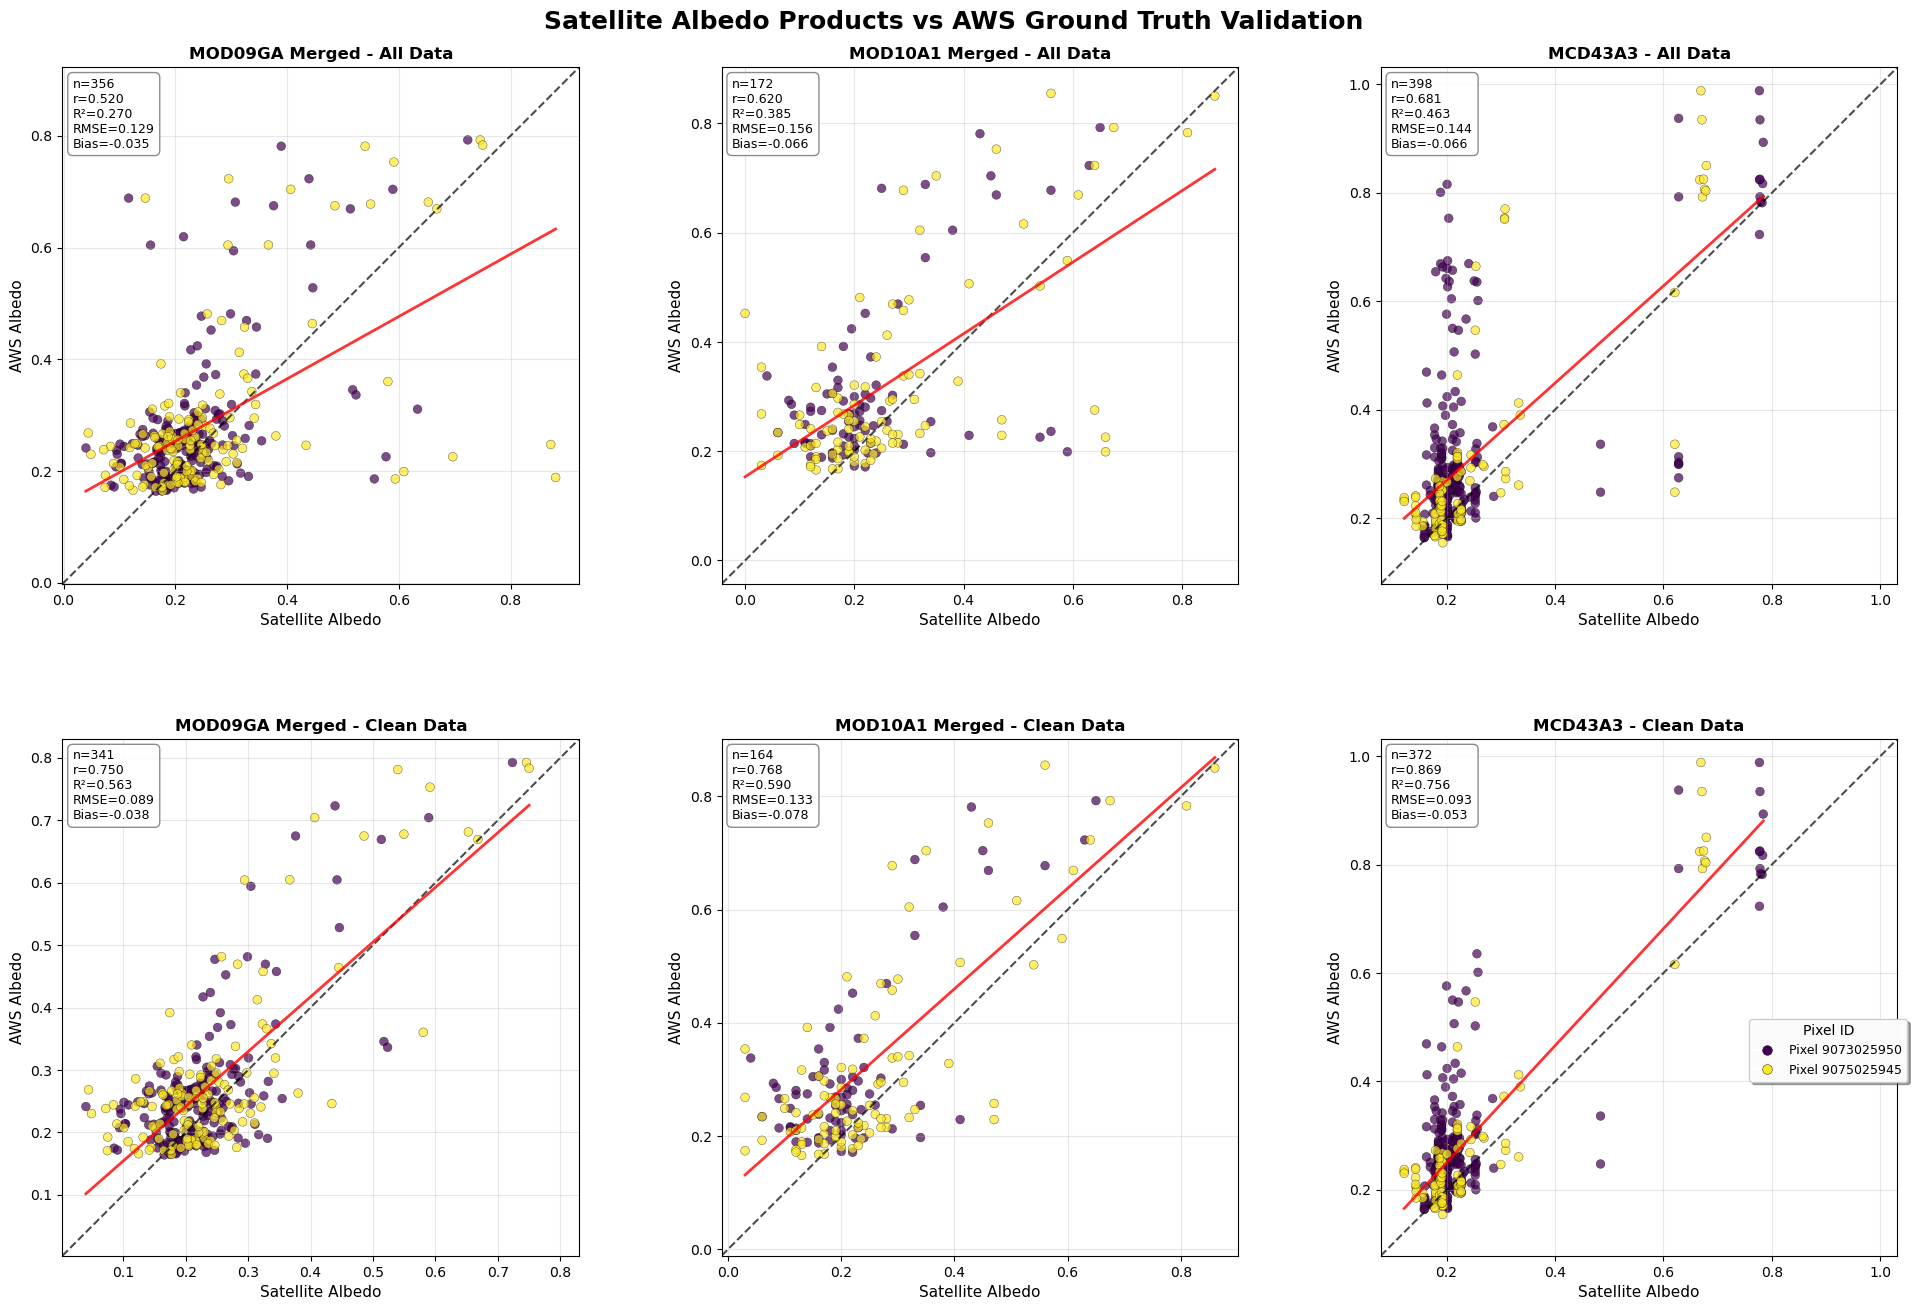


=== VALIDATION STATISTICS (outliers removed) ===
Product       | n    | r     | R²    | Bias  | RMSE  | MAE   
-----------------------------------------------------------------
MOD09GA Merged |  341 | 0.750 | 0.563 | -0.038 | 0.089 | 0.066
MOD10A1 Merged |  164 | 0.768 | 0.590 | -0.078 | 0.133 | 0.102
MCD43A3      |  372 | 0.869 | 0.756 | -0.053 | 0.093 | 0.062

Dataset: 1249/1298 points (3.8% outliers removed)


In [21]:
# Satellite Albedo vs AWS Validation Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuration
plt.style.use('default')
sns.set_palette("husl")

PRODUCTS = [
    {'name': 'merged_albedo_mod09ga', 'title': 'MOD09GA Merged', 'color': 'skyblue', 'edge': 'navy'},
    {'name': 'merged_albedo_mod10a1', 'title': 'MOD10A1 Merged', 'color': 'forestgreen', 'edge': 'darkgreen'},
    {'name': 'albedo_mcd43a3', 'title': 'MCD43A3', 'color': 'orange', 'edge': 'darkorange'}
]

# Global color mapping for pixel_id consistency
unique_pixel_ids = np.unique(df_with_flags['pixel_id'])
cmap = plt.get_cmap('viridis', len(unique_pixel_ids))
pixel_colors = {pid: cmap(i) for i, pid in enumerate(unique_pixel_ids)}

# Helper Functions
def calculate_stats(y_true, y_pred):
    """Calculate validation statistics"""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    if not np.any(mask):
        return {'bias': np.nan, 'r': np.nan, 'rmse': np.nan, 'mae': np.nan, 'n': 0}
    
    y_clean, pred_clean = y_true[mask], y_pred[mask]
    return {
        'bias': np.mean(pred_clean - y_clean),
        'r': np.corrcoef(y_clean, pred_clean)[0, 1],
        'rmse': np.sqrt(mean_squared_error(y_clean, pred_clean)),
        'mae': mean_absolute_error(y_clean, pred_clean),
        'n': len(y_clean)
    }

def plot_scatter(ax, x, y, title, stats, color='blue', edge='darkblue'):
    """Create scatter plot with regression and statistics"""
    # Clean data
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    # Scatter plot with pixel coloring
    pixel_ids = df_with_flags['pixel_id'].values[mask] if len(x) == len(df_with_flags) else df_no_outliers['pixel_id'].values[mask]
    colors = [pixel_colors[pid] for pid in pixel_ids]
    ax.scatter(x_clean, y_clean, c=colors, alpha=0.7, s=40, edgecolors='black', linewidth=0.3)
    
    # Set consistent square limits for all plots
    min_val = min(np.min(x_clean), np.min(y_clean))
    max_val = max(np.max(x_clean), np.max(y_clean))
    # Add padding for better visualization
    padding = (max_val - min_val) * 0.05
    lims = [min_val - padding, max_val + padding]
    
    # Reference line (1:1)
    ax.plot(lims, lims, 'k--', alpha=0.7, linewidth=1.5)  # 1:1 line
    
    # Regression line only across data range
    if len(x_clean) > 1:
        coeffs = np.polyfit(x_clean, y_clean, 1)
        x_data_range = [np.min(x_clean), np.max(x_clean)]
        y_reg_range = coeffs[0] * np.array(x_data_range) + coeffs[1]
        ax.plot(x_data_range, y_reg_range, 'r-', linewidth=2, alpha=0.8)
    
    # Statistics box
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    stats_text = f"n={stats['n']}\nr={stats['r']:.3f}\nR²={r2:.3f}\nRMSE={stats['rmse']:.3f}\nBias={stats['bias']:.3f}"
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))
    
    # Formatting with consistent square limits
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xlabel('Satellite Albedo', fontsize=11)
    ax.set_ylabel('AWS Albedo', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Main Plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Satellite Albedo Products vs AWS Ground Truth Validation', fontsize=18, fontweight='bold', y=0.95)

# Create plots for each product
for i, product in enumerate(PRODUCTS):
    # All data (top row)
    stats_all = calculate_stats(df_with_flags['albedo_aws'].values, df_with_flags[product['name']].values)
    plot_scatter(axes[0, i], df_with_flags[product['name']].values, df_with_flags['albedo_aws'].values,
                f"{product['title']} - All Data", stats_all, product['color'], product['edge'])
    
    # Clean data (bottom row)
    stats_clean = calculate_stats(df_no_outliers['albedo_aws'].values, df_no_outliers[product['name']].values)
    plot_scatter(axes[1, i], df_no_outliers[product['name']].values, df_no_outliers['albedo_aws'].values,
                f"{product['title']} - Clean Data", stats_clean, product['color'], product['edge'])

# Legend for pixel IDs
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=7, markeredgecolor='black', markeredgewidth=0.3, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower right', fontsize=9, title_fontsize=10,
           frameon=True, fancybox=True, shadow=True, framealpha=0.97, bbox_to_anchor=(0.98, 0.18))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.1)
plt.show()

# Summary Statistics Table
print("\n=== VALIDATION STATISTICS (outliers removed) ===")
print("Product       | n    | r     | R²    | Bias  | RMSE  | MAE   ")
print("-" * 65)
for product in PRODUCTS:
    stats = calculate_stats(df_no_outliers['albedo_aws'].values, df_no_outliers[product['name']].values)
    r2 = stats['r']**2 if not np.isnan(stats['r']) else np.nan
    print(f"{product['title']:12} | {stats['n']:4d} | {stats['r']:5.3f} | {r2:5.3f} | {stats['bias']:5.3f} | {stats['rmse']:5.3f} | {stats['mae']:5.3f}")

print(f"\nDataset: {len(df_no_outliers)}/{len(df_with_flags)} points ({(len(df_with_flags)-len(df_no_outliers))/len(df_with_flags)*100:.1f}% outliers removed)")

=== MOD09GA ENVIRONMENTAL ANALYSIS ===

NDSI Analysis:
  Data points: 285
  NDSI range: -0.144 to 0.933
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.050 (p=0.404)
  Correlation with |residuals|: r=-0.121 (p=0.042)

Solar Zenith Analysis:
  Data points: 285
  Solar Zenith range: 28.800 to 56.150
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=-0.317 (p=0.000)
  Correlation with |residuals|: r=0.405 (p=0.000)

Glacier Fraction Analysis:
  Data points: 285
  Glacier Fraction range: 0.659 to 0.969
  Residual range: -0.310 to 0.220
  Correlation with residuals: r=0.042 (p=0.478)
  Correlation with |residuals|: r=-0.120 (p=0.042)


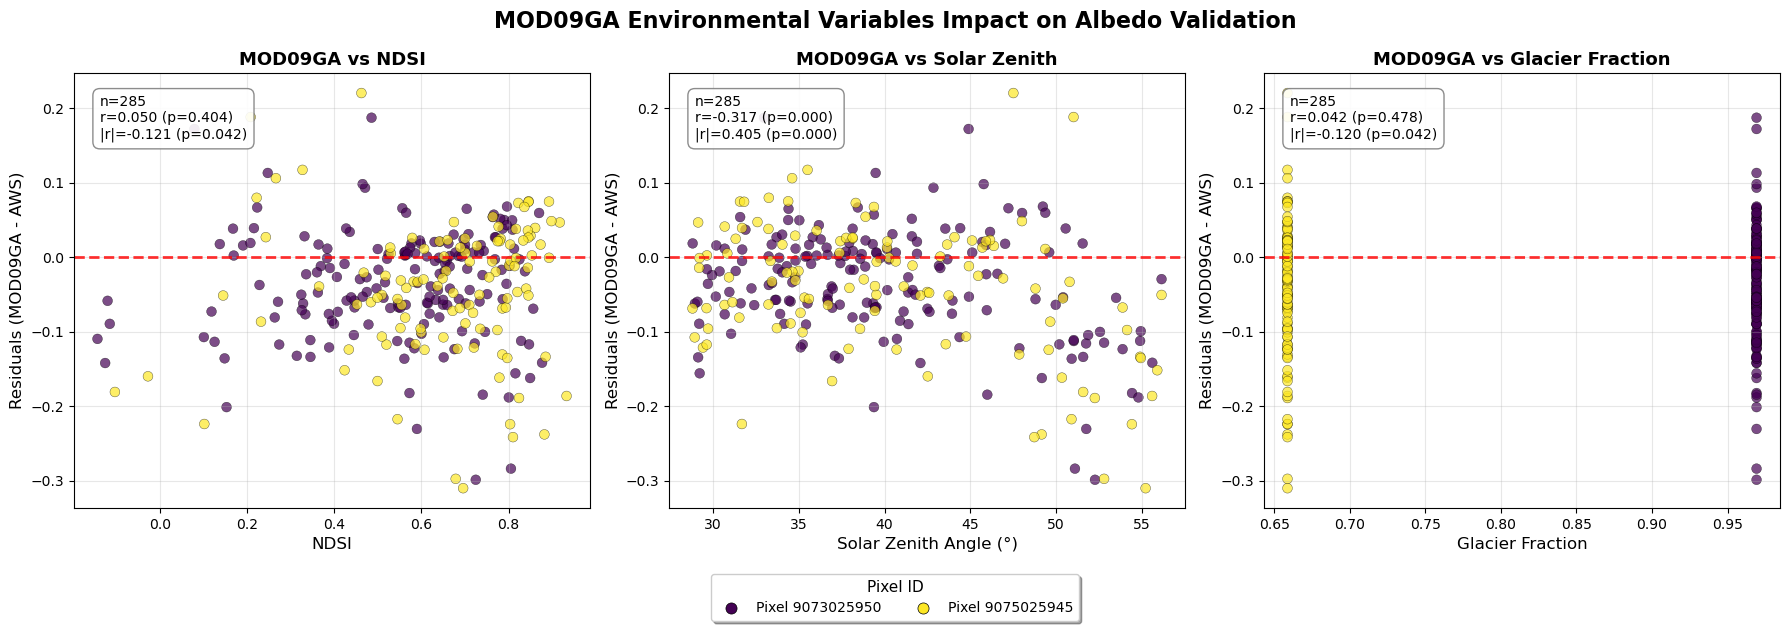


Analysis based on 1249 clean data points


In [27]:
# MOD09GA Environmental Impact Analysis: NDSI, Solar Zenith, and Glacier Fraction
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

def analyze_environmental_impact(df, env_var, product_col, reference_col='albedo_aws'):
    """Analyze how environmental variables affect validation performance"""
    # Check if columns exist and remove NaN values
    mask = ~(np.isnan(df[env_var]) | np.isnan(df[product_col]) | np.isnan(df[reference_col]))
    data = df[mask].copy()
    
    if len(data) < 5:
        return None
    
    # Calculate residuals
    data['residuals'] = data[product_col] - data[reference_col]
    data['abs_residuals'] = np.abs(data['residuals'])
    
    return data

# MOD09GA Environmental Analysis
product_col = 'merged_albedo_mod09ga'
env_variables = [
    ('ndsi_mod09ga', 'NDSI', 'NDSI'),
    ('solar_zenith_mod09ga', 'Solar Zenith Angle (°)', 'Solar Zenith'),  
    ('glacier_fraction_mod09ga', 'Glacier Fraction', 'Glacier Fraction')
]

# Create 1x3 subplot for MOD09GA only
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('MOD09GA Environmental Variables Impact on Albedo Validation', fontsize=16, fontweight='bold')

print("=== MOD09GA ENVIRONMENTAL ANALYSIS ===")

for i, (env_var, xlabel, title) in enumerate(env_variables):
    if env_var in df_no_outliers.columns:
        data = analyze_environmental_impact(df_no_outliers, env_var, product_col)
        
        if data is not None and len(data) > 0:
            print(f"\n{title} Analysis:")
            print(f"  Data points: {len(data)}")
            print(f"  {title} range: {data[env_var].min():.3f} to {data[env_var].max():.3f}")
            print(f"  Residual range: {data['residuals'].min():.3f} to {data['residuals'].max():.3f}")
            
            # Scatter plot with pixel coloring
            colors = [pixel_colors[pid] for pid in data['pixel_id']]
            axes[i].scatter(data[env_var], data['residuals'], c=colors, alpha=0.7, s=50, 
                           edgecolors='black', linewidth=0.3)
            
            # Zero line
            axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
            
            # Formatting
            axes[i].set_xlabel(xlabel, fontsize=12)
            axes[i].set_ylabel('Residuals (MOD09GA - AWS)', fontsize=12)
            axes[i].set_title(f'MOD09GA vs {title}', fontsize=13, fontweight='bold')
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation statistics
            try:
                r, p = stats.pearsonr(data[env_var], data['residuals'])
                r_abs, p_abs = stats.pearsonr(data[env_var], data['abs_residuals'])
                
                stats_text = f'n={len(data)}\nr={r:.3f} (p={p:.3f})\n|r|={r_abs:.3f} (p={p_abs:.3f})'
                axes[i].text(0.05, 0.95, stats_text, transform=axes[i].transAxes, 
                           fontsize=10, va='top', ha='left',
                           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='gray'))
                
                print(f"  Correlation with residuals: r={r:.3f} (p={p:.3f})")
                print(f"  Correlation with |residuals|: r={r_abs:.3f} (p={p_abs:.3f})")
                
            except Exception as e:
                print(f"  Could not calculate correlations: {e}")
        else:
            axes[i].text(0.5, 0.5, f'Insufficient data\nfor {title} analysis', 
                        transform=axes[i].transAxes, ha='center', va='center', fontsize=12)
            axes[i].set_title(f'MOD09GA vs {title}', fontsize=13)
            print(f"\n{title}: Insufficient data for analysis")
    else:
        axes[i].text(0.5, 0.5, f'{title} column\nnot found', 
                    transform=axes[i].transAxes, ha='center', va='center', fontsize=12)
        axes[i].set_title(f'MOD09GA vs {title}', fontsize=13)
        print(f"\n{title}: Column '{env_var}' not found")

# Add pixel legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=pixel_colors[pid], 
                           markersize=8, markeredgecolor='black', markeredgewidth=0.5, label=f'Pixel {pid}') 
                 for pid in sorted(pixel_colors.keys())]
fig.legend(handles=legend_handles, title='Pixel ID', loc='lower center', ncol=len(pixel_colors), 
           fontsize=10, title_fontsize=11, frameon=True, fancybox=True, shadow=True, 
           bbox_to_anchor=(0.5, -0.05))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

print(f"\nAnalysis based on {len(df_no_outliers)} clean data points")

=== SOLAR ZENITH ANGLE vs DATE ANALYSIS ===
Data points: 398
Date range: 2014-06-01 to 2020-09-30
Day of year range: 152 to 274
Solar zenith range: 28.770° to 56.150°
Correlation (day of year vs solar zenith): r=0.952 (p=0.000)
R² = 0.906 (90.6% of variance explained)

Monthly Solar Zenith Statistics:
         mean    std  count
month                      
6      30.346  1.409     50
7      33.638  2.470    111
8      40.032  2.965    128
9      50.651  3.435    109


C:\Users\thier\AppData\Local\Temp\ipykernel_26072\887260110.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(monthly_data, labels=[month_labels[m-1] for m in months])


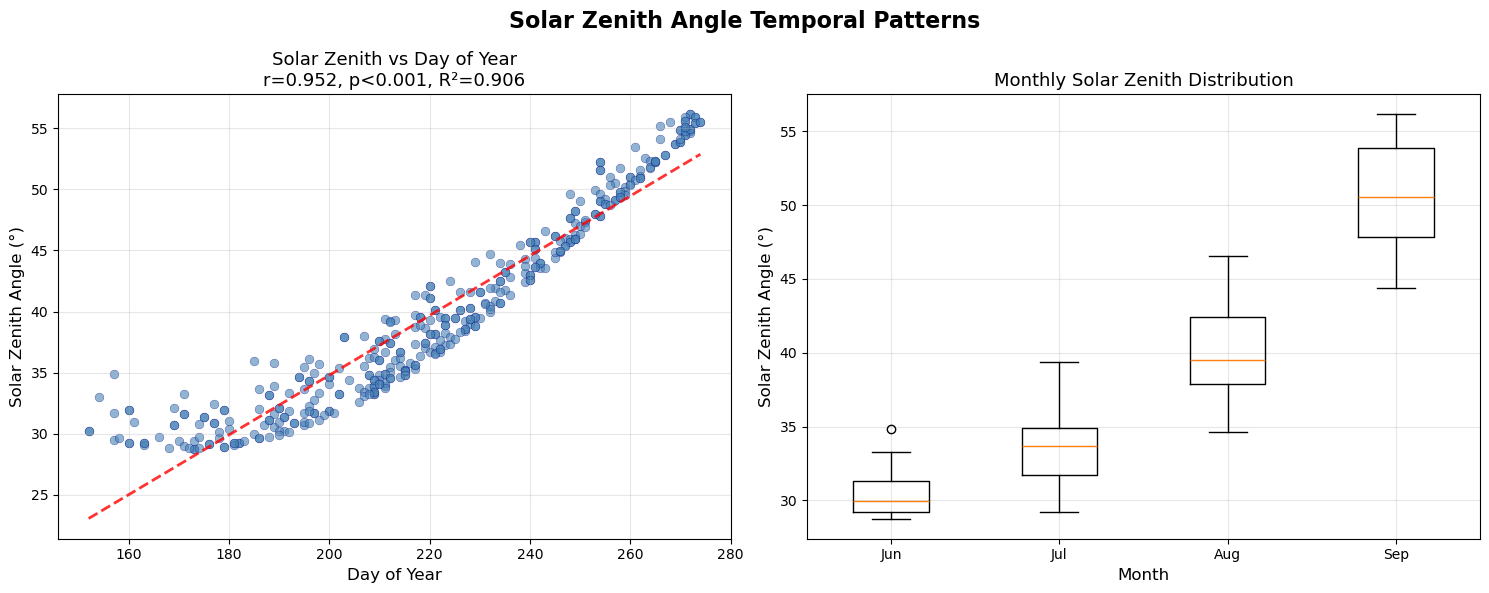


=== INTERPRETATION ===
• Very strong correlation (r=0.952) between day of year and solar zenith angle
• 90.6% of solar zenith variation explained by seasonal position
• Data spans June-September (day 152-274)
• Solar zenith increases 0.245°/day through summer-autumn transition


In [5]:
# Solar Zenith Angle vs Date Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Convert date column to datetime and extract day of year
df_no_outliers_copy = df_no_outliers.copy()
df_no_outliers_copy['date'] = pd.to_datetime(df_no_outliers_copy['date'])
df_no_outliers_copy['day_of_year'] = df_no_outliers_copy['date'].dt.dayofyear

# Remove NaN values for solar zenith analysis
mask = ~np.isnan(df_no_outliers_copy['solar_zenith_mod09ga'])
data_clean = df_no_outliers_copy[mask].copy()

print("=== SOLAR ZENITH ANGLE vs DATE ANALYSIS ===")
print(f"Data points: {len(data_clean)}")
print(f"Date range: {data_clean['date'].min().strftime('%Y-%m-%d')} to {data_clean['date'].max().strftime('%Y-%m-%d')}")
print(f"Day of year range: {data_clean['day_of_year'].min()} to {data_clean['day_of_year'].max()}")
print(f"Solar zenith range: {data_clean['solar_zenith_mod09ga'].min():.3f}° to {data_clean['solar_zenith_mod09ga'].max():.3f}°")

# Calculate correlation
r_doy, p_doy = stats.pearsonr(data_clean['day_of_year'], data_clean['solar_zenith_mod09ga'])
print(f"Correlation (day of year vs solar zenith): r={r_doy:.3f} (p={p_doy:.3f})")
print(f"R² = {r_doy**2:.3f} ({r_doy**2*100:.1f}% of variance explained)")

# Monthly aggregation
data_clean['month'] = data_clean['date'].dt.month
monthly_stats = data_clean.groupby('month')['solar_zenith_mod09ga'].agg(['mean', 'std', 'count']).round(3)
print(f"\nMonthly Solar Zenith Statistics:")
print(monthly_stats)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Solar Zenith Angle Temporal Patterns', fontsize=16, fontweight='bold')

# Plot 1: Solar zenith vs day of year
ax1.scatter(data_clean['day_of_year'], data_clean['solar_zenith_mod09ga'], 
           alpha=0.6, s=40, c='steelblue', edgecolors='navy', linewidth=0.3)

# Add trend line
z = np.polyfit(data_clean['day_of_year'], data_clean['solar_zenith_mod09ga'], 1)
p = np.poly1d(z)
ax1.plot(data_clean['day_of_year'], p(data_clean['day_of_year']), "r--", alpha=0.8, linewidth=2)

ax1.set_xlabel('Day of Year', fontsize=12)
ax1.set_ylabel('Solar Zenith Angle (°)', fontsize=12)
ax1.set_title(f'Solar Zenith vs Day of Year\nr={r_doy:.3f}, p<0.001, R²={r_doy**2:.3f}', fontsize=13)
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly boxplot
monthly_data = [data_clean[data_clean['month'] == m]['solar_zenith_mod09ga'].values 
                for m in sorted(data_clean['month'].unique())]
months = sorted(data_clean['month'].unique())
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax2.boxplot(monthly_data, labels=[month_labels[m-1] for m in months])
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Solar Zenith Angle (°)', fontsize=12)
ax2.set_title('Monthly Solar Zenith Distribution', fontsize=13)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check seasonal patterns
winter_months = [12, 1, 2]
summer_months = [6, 7, 8]

winter_data = data_clean[data_clean['month'].isin(winter_months)]
summer_data = data_clean[data_clean['month'].isin(summer_months)]

if len(winter_data) > 0 and len(summer_data) > 0:
    print(f"\n=== SEASONAL COMPARISON ===")
    print(f"Winter (Dec-Feb): Mean solar zenith = {winter_data['solar_zenith_mod09ga'].mean():.3f}° (n={len(winter_data)})")
    print(f"Summer (Jun-Aug): Mean solar zenith = {summer_data['solar_zenith_mod09ga'].mean():.3f}° (n={len(summer_data)})")
    print(f"Difference: {winter_data['solar_zenith_mod09ga'].mean() - summer_data['solar_zenith_mod09ga'].mean():.3f}°")

print(f"\n=== INTERPRETATION ===")
print(f"• Very strong correlation (r={r_doy:.3f}) between day of year and solar zenith angle")
print(f"• {r_doy**2*100:.1f}% of solar zenith variation explained by seasonal position")
print(f"• Data spans June-September (day {data_clean['day_of_year'].min()}-{data_clean['day_of_year'].max()})")
print(f"• Solar zenith increases {z[0]:.3f}°/day through summer-autumn transition")

=== SOLAR ZENITH ANGLE ERROR THRESHOLD ANALYSIS ===
Total data points: 285
Solar zenith range: 28.8° to 56.1°

Error Statistics by Solar Zenith Angle Bins:
              bias  bias_std  count     mae  mae_std  rel_bias  rel_bias_std
zenith_bin                                                                  
28-31°     -0.0456    0.0533     29  0.0552   0.0428  -16.2085       19.4687
31-34°     -0.0126    0.0715     34  0.0543   0.0473   -4.4731       27.8187
34-37°     -0.0200    0.0581     50  0.0486   0.0371   -6.8649       26.0767
37-40°     -0.0206    0.0625     48  0.0483   0.0442   -7.8012       28.5177
40-43°     -0.0334    0.0571     32  0.0508   0.0418  -12.3930       25.9230
43-46°     -0.0152    0.0695     28  0.0502   0.0496   -5.6662       25.1404
46-49°     -0.0108    0.1055     15  0.0751   0.0721    1.6976       27.5029
49-52°     -0.0865    0.1075     27  0.1153   0.0742  -21.7194       33.5075
52-55°     -0.1513    0.0734     16  0.1513   0.0734  -32.9132        9.47

C:\Users\thier\AppData\Local\Temp\ipykernel_26072\595203363.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = analysis_data.groupby('zenith_bin').agg({


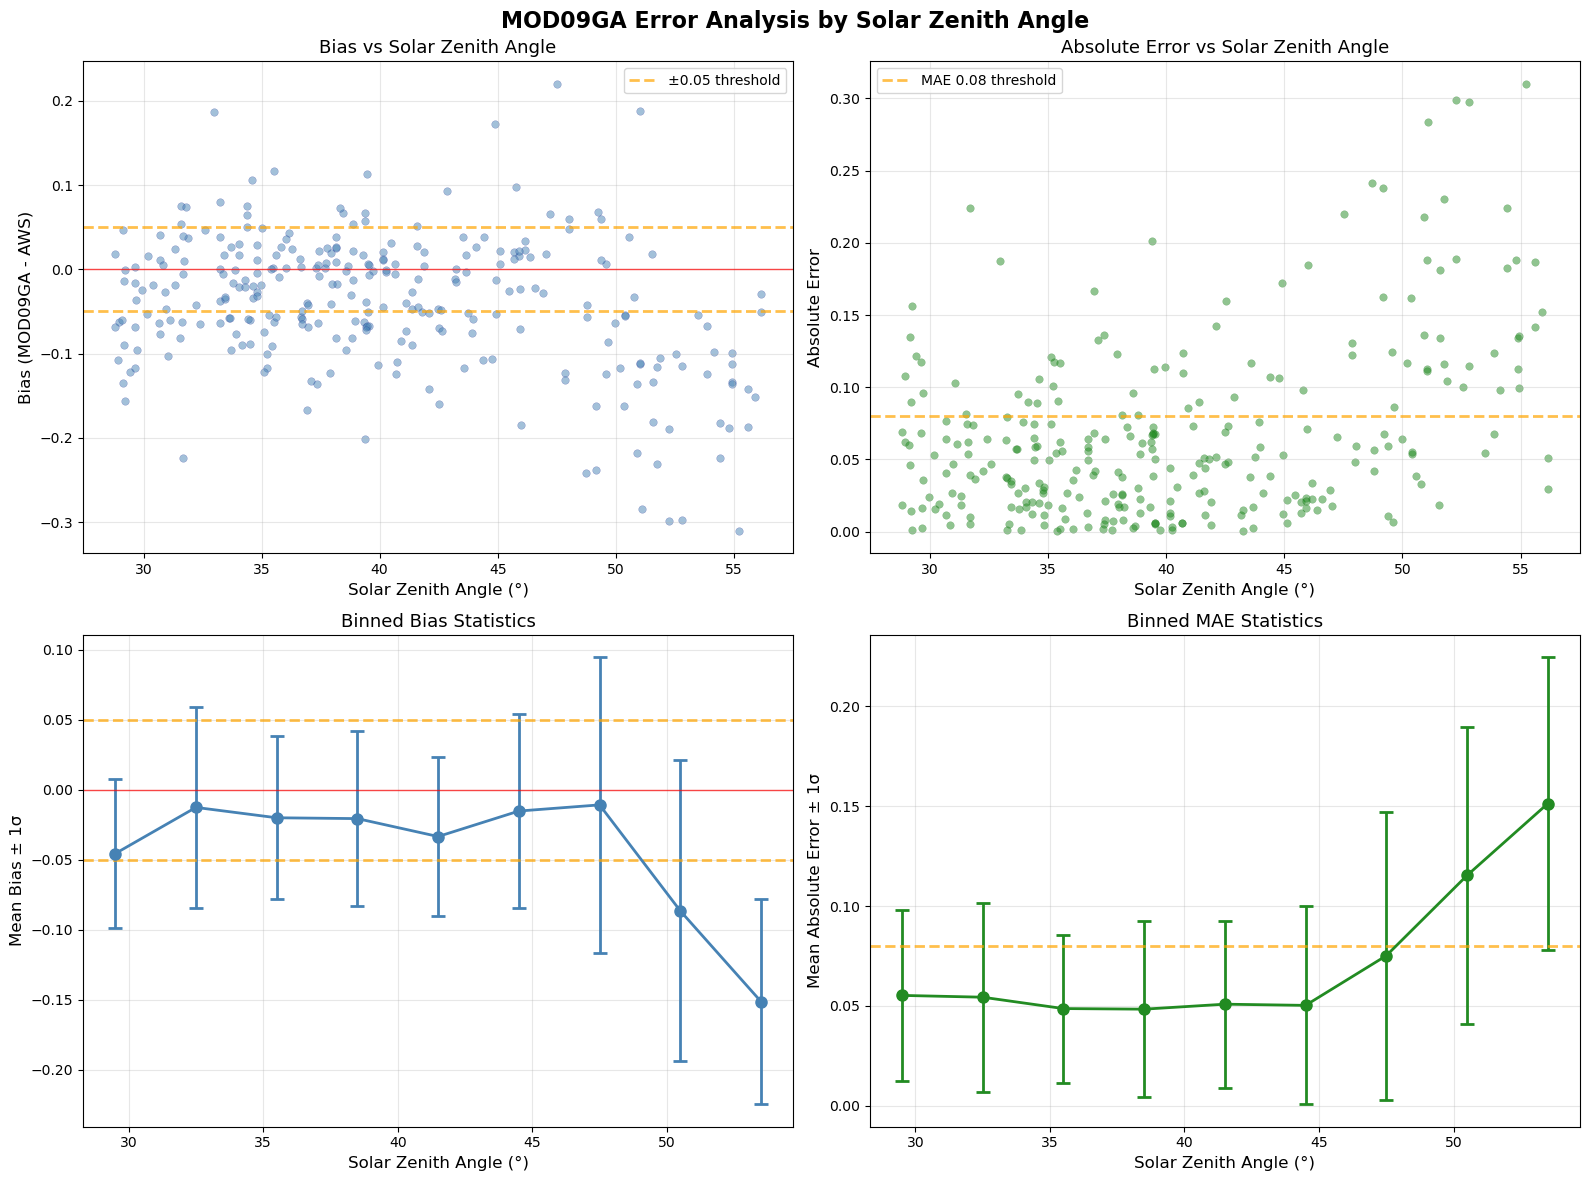


=== CRITICAL ANGLE FINDINGS ===
First occurrence of MAE > 0.08: 28.9°
Points exceeding MAE threshold: 82 / 285 (28.8%)

Below 28.9° (n=2):
  Mean bias = -0.0253
  Mean MAE = 0.0436
Above 28.9° (n=283):
  Mean bias = -0.0388
  Mean MAE = 0.0660


In [7]:
# Solar Zenith Angle Error Threshold Analysis
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats

# Get MOD09GA data with solar zenith and calculate errors
mask = ~(np.isnan(df_no_outliers['solar_zenith_mod09ga']) | 
         np.isnan(df_no_outliers['merged_albedo_mod09ga']) | 
         np.isnan(df_no_outliers['albedo_aws']))
analysis_data = df_no_outliers[mask].copy()

# Calculate errors and residuals
analysis_data['residuals'] = analysis_data['merged_albedo_mod09ga'] - analysis_data['albedo_aws']
analysis_data['abs_residuals'] = np.abs(analysis_data['residuals'])
analysis_data['relative_error'] = (analysis_data['residuals'] / analysis_data['albedo_aws']) * 100

print("=== SOLAR ZENITH ANGLE ERROR THRESHOLD ANALYSIS ===")
print(f"Total data points: {len(analysis_data)}")
print(f"Solar zenith range: {analysis_data['solar_zenith_mod09ga'].min():.1f}° to {analysis_data['solar_zenith_mod09ga'].max():.1f}°")

# Define solar zenith bins for analysis
zenith_bins = np.arange(28, 58, 3)  # 3-degree bins
analysis_data['zenith_bin'] = pd.cut(analysis_data['solar_zenith_mod09ga'], bins=zenith_bins, 
                                   labels=[f"{int(zenith_bins[i])}-{int(zenith_bins[i+1])}°" 
                                          for i in range(len(zenith_bins)-1)])

# Calculate statistics by zenith bin
bin_stats = analysis_data.groupby('zenith_bin').agg({
    'residuals': ['mean', 'std', 'count'],
    'abs_residuals': ['mean', 'std'],
    'relative_error': ['mean', 'std']
}).round(4)

bin_stats.columns = ['bias', 'bias_std', 'count', 'mae', 'mae_std', 'rel_bias', 'rel_bias_std']
print(f"\nError Statistics by Solar Zenith Angle Bins:")
print(bin_stats)

# Define error thresholds
bias_threshold = 0.05  # 5% albedo units
mae_threshold = 0.08   # Mean absolute error threshold
rel_error_threshold = 10  # 10% relative error

print(f"\n=== ERROR THRESHOLD ANALYSIS ===")
print(f"Bias threshold: ±{bias_threshold:.3f} albedo units")
print(f"MAE threshold: {mae_threshold:.3f} albedo units") 
print(f"Relative error threshold: ±{rel_error_threshold}%")

# Find critical zenith angles
critical_bias = bin_stats[np.abs(bin_stats['bias']) > bias_threshold]
critical_mae = bin_stats[bin_stats['mae'] > mae_threshold]
critical_rel = bin_stats[np.abs(bin_stats['rel_bias']) > rel_error_threshold]

if len(critical_bias) > 0:
    print(f"\nSolar zenith bins exceeding bias threshold:")
    for idx in critical_bias.index:
        print(f"  {idx}: bias = {critical_bias.loc[idx, 'bias']:.4f}")

if len(critical_mae) > 0:
    print(f"\nSolar zenith bins exceeding MAE threshold:")
    for idx in critical_mae.index:
        print(f"  {idx}: MAE = {critical_mae.loc[idx, 'mae']:.4f}")

if len(critical_rel) > 0:
    print(f"\nSolar zenith bins exceeding relative error threshold:")
    for idx in critical_rel.index:
        print(f"  {idx}: relative bias = {critical_rel.loc[idx, 'rel_bias']:.1f}%")

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('MOD09GA Error Analysis by Solar Zenith Angle', fontsize=16, fontweight='bold')

# Plot 1: Bias vs Solar Zenith
ax1.scatter(analysis_data['solar_zenith_mod09ga'], analysis_data['residuals'], 
           alpha=0.5, s=30, c='steelblue', edgecolors='navy', linewidth=0.2)
ax1.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=1)
ax1.axhline(y=bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2, label=f'±{bias_threshold} threshold')
ax1.axhline(y=-bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax1.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax1.set_ylabel('Bias (MOD09GA - AWS)', fontsize=12)
ax1.set_title('Bias vs Solar Zenith Angle', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Absolute Error vs Solar Zenith  
ax2.scatter(analysis_data['solar_zenith_mod09ga'], analysis_data['abs_residuals'], 
           alpha=0.5, s=30, c='forestgreen', edgecolors='darkgreen', linewidth=0.2)
ax2.axhline(y=mae_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2, label=f'MAE {mae_threshold} threshold')
ax2.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax2.set_ylabel('Absolute Error', fontsize=12)
ax2.set_title('Absolute Error vs Solar Zenith Angle', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Binned statistics - Bias
bin_centers = [float(idx.split('-')[0]) + 1.5 for idx in bin_stats.index]
ax3.errorbar(bin_centers, bin_stats['bias'], yerr=bin_stats['bias_std'], 
            fmt='o-', color='steelblue', capsize=5, capthick=2, linewidth=2, markersize=8)
ax3.axhline(y=0, color='red', linestyle='-', alpha=0.7, linewidth=1)
ax3.axhline(y=bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax3.axhline(y=-bias_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax3.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax3.set_ylabel('Mean Bias ± 1σ', fontsize=12)
ax3.set_title('Binned Bias Statistics', fontsize=13)
ax3.grid(True, alpha=0.3)

# Plot 4: Binned statistics - MAE
ax4.errorbar(bin_centers, bin_stats['mae'], yerr=bin_stats['mae_std'], 
            fmt='o-', color='forestgreen', capsize=5, capthick=2, linewidth=2, markersize=8)
ax4.axhline(y=mae_threshold, color='orange', linestyle='--', alpha=0.7, linewidth=2)
ax4.set_xlabel('Solar Zenith Angle (°)', fontsize=12)
ax4.set_ylabel('Mean Absolute Error ± 1σ', fontsize=12)
ax4.set_title('Binned MAE Statistics', fontsize=13)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find specific critical angle
high_error_data = analysis_data[analysis_data['abs_residuals'] > mae_threshold]
if len(high_error_data) > 0:
    min_critical_angle = high_error_data['solar_zenith_mod09ga'].min()
    print(f"\n=== CRITICAL ANGLE FINDINGS ===")
    print(f"First occurrence of MAE > {mae_threshold}: {min_critical_angle:.1f}°")
    print(f"Points exceeding MAE threshold: {len(high_error_data)} / {len(analysis_data)} ({len(high_error_data)/len(analysis_data)*100:.1f}%)")
    
    # Statistics above/below critical angle
    below_critical = analysis_data[analysis_data['solar_zenith_mod09ga'] < min_critical_angle]
    above_critical = analysis_data[analysis_data['solar_zenith_mod09ga'] >= min_critical_angle]
    
    print(f"\nBelow {min_critical_angle:.1f}° (n={len(below_critical)}):")
    print(f"  Mean bias = {below_critical['residuals'].mean():.4f}")
    print(f"  Mean MAE = {below_critical['abs_residuals'].mean():.4f}")
    
    print(f"Above {min_critical_angle:.1f}° (n={len(above_critical)}):")
    print(f"  Mean bias = {above_critical['residuals'].mean():.4f}")
    print(f"  Mean MAE = {above_critical['abs_residuals'].mean():.4f}")
else:
    print(f"\nNo points exceed the MAE threshold of {mae_threshold}")

=== DATES CORRESPONDING TO CRITICAL SOLAR ZENITH ANGLES ===
Performance thresholds:
  Good performance: < 46°
  Degraded performance: 46-49°
  Poor performance: > 49°
  Unacceptable: > 52°

Good→Degraded transition (~46°):
  Approximate date: 2019-11-17 (day 248)
  Date range: 2018-09-04 to 2020-09-05

Degraded→Poor transition (~49°):
  Approximate date: 2016-04-19 (day 256)
  Date range: 2014-09-14 to 2020-09-11

Poor→Unacceptable transition (~52°):
  Approximate date: 2016-07-08 (day 263)
  Date range: 2014-09-15 to 2019-09-21

=== MONTHLY PERFORMANCE BREAKDOWN ===
Performance zone by month (% of observations):
Month      | Good  | Degraded | Poor  | Unacceptable
-------------------------------------------------------
June       | 100.0 |      0.0 |   0.0 |          0.0
July       | 100.0 |      0.0 |   0.0 |          0.0
August     |  99.1 |      0.9 |   0.0 |          0.0
September  |  13.7 |     19.2 |  37.0 |         30.1


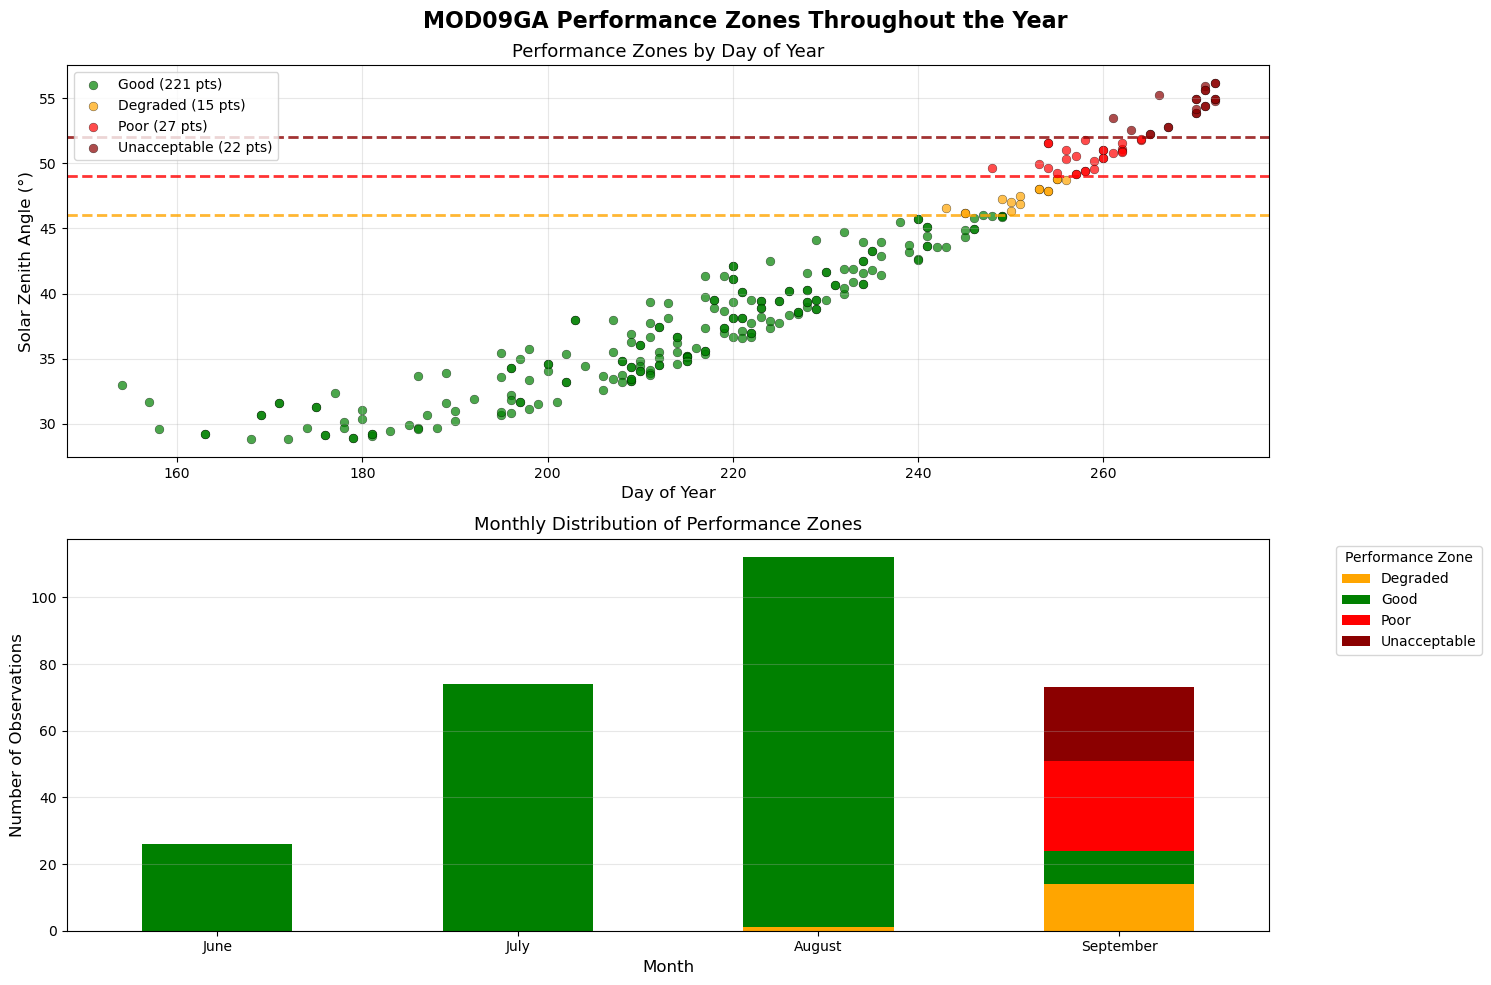


=== TEMPORAL USAGE RECOMMENDATIONS ===
• Optimal MOD09GA performance: June-early August
• Acceptable performance: Through mid-August
• Degraded performance: Late August
• Poor/Unacceptable: September
• Critical transition occurs around late August (day ~240)

• 49° threshold (degraded→poor) occurs around: juin 13
  (Day of year: 256)


In [8]:
# Date Analysis for Critical Solar Zenith Angles
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add date information to analysis data
analysis_data['date'] = pd.to_datetime(df_no_outliers.loc[analysis_data.index, 'date'])
analysis_data['month'] = analysis_data['date'].dt.month
analysis_data['day_of_year'] = analysis_data['date'].dt.dayofyear

print("=== DATES CORRESPONDING TO CRITICAL SOLAR ZENITH ANGLES ===")

# Define critical thresholds identified earlier
good_performance_threshold = 46  # Up to 46° - good performance
degraded_threshold = 49  # 49° - performance starts degrading significantly  
poor_threshold = 52  # 52° - poor performance, unacceptable errors

print(f"Performance thresholds:")
print(f"  Good performance: < {good_performance_threshold}°")
print(f"  Degraded performance: {good_performance_threshold}-{degraded_threshold}°") 
print(f"  Poor performance: > {degraded_threshold}°")
print(f"  Unacceptable: > {poor_threshold}°")

# Find dates corresponding to each threshold
for threshold, label in [(good_performance_threshold, "Good→Degraded"), 
                        (degraded_threshold, "Degraded→Poor"),
                        (poor_threshold, "Poor→Unacceptable")]:
    
    # Find data points near threshold
    threshold_data = analysis_data[
        (analysis_data['solar_zenith_mod09ga'] >= threshold - 1) & 
        (analysis_data['solar_zenith_mod09ga'] <= threshold + 1)
    ].copy()
    
    if len(threshold_data) > 0:
        # Get representative date around threshold
        closest_to_threshold = threshold_data.iloc[
            (threshold_data['solar_zenith_mod09ga'] - threshold).abs().argsort()[:5]
        ]
        
        mean_date = closest_to_threshold['date'].mean()
        mean_doy = closest_to_threshold['day_of_year'].mean()
        date_range = f"{closest_to_threshold['date'].min().strftime('%Y-%m-%d')} to {closest_to_threshold['date'].max().strftime('%Y-%m-%d')}"
        
        print(f"\n{label} transition (~{threshold}°):")
        print(f"  Approximate date: {mean_date.strftime('%Y-%m-%d')} (day {mean_doy:.0f})")
        print(f"  Date range: {date_range}")

# Monthly breakdown of performance zones
print(f"\n=== MONTHLY PERFORMANCE BREAKDOWN ===")

# Categorize each data point by performance zone
analysis_data['performance_zone'] = 'Good'
analysis_data.loc[analysis_data['solar_zenith_mod09ga'] >= good_performance_threshold, 'performance_zone'] = 'Degraded'
analysis_data.loc[analysis_data['solar_zenith_mod09ga'] >= degraded_threshold, 'performance_zone'] = 'Poor'
analysis_data.loc[analysis_data['solar_zenith_mod09ga'] >= poor_threshold, 'performance_zone'] = 'Unacceptable'

# Monthly performance summary
monthly_performance = pd.crosstab(analysis_data['month'], analysis_data['performance_zone'], 
                                normalize='index') * 100

month_names = {6: 'June', 7: 'July', 8: 'August', 9: 'September'}
print("Performance zone by month (% of observations):")
print("Month      | Good  | Degraded | Poor  | Unacceptable")
print("-" * 55)

for month in sorted(analysis_data['month'].unique()):
    month_name = month_names.get(month, f"Month {month}")
    row_data = monthly_performance.loc[month] if month in monthly_performance.index else pd.Series()
    
    good = row_data.get('Good', 0)
    degraded = row_data.get('Degraded', 0) 
    poor = row_data.get('Poor', 0)
    unacceptable = row_data.get('Unacceptable', 0)
    
    print(f"{month_name:10} | {good:5.1f} | {degraded:8.1f} | {poor:5.1f} | {unacceptable:12.1f}")

# Create temporal visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('MOD09GA Performance Zones Throughout the Year', fontsize=16, fontweight='bold')

# Plot 1: Solar zenith vs day of year with performance zones
colors = {'Good': 'green', 'Degraded': 'orange', 'Poor': 'red', 'Unacceptable': 'darkred'}
for zone in ['Good', 'Degraded', 'Poor', 'Unacceptable']:
    zone_data = analysis_data[analysis_data['performance_zone'] == zone]
    if len(zone_data) > 0:
        ax1.scatter(zone_data['day_of_year'], zone_data['solar_zenith_mod09ga'], 
                   c=colors[zone], label=f'{zone} ({len(zone_data)} pts)', 
                   alpha=0.7, s=40, edgecolors='black', linewidth=0.3)

# Add threshold lines
ax1.axhline(y=good_performance_threshold, color='orange', linestyle='--', alpha=0.8, linewidth=2)
ax1.axhline(y=degraded_threshold, color='red', linestyle='--', alpha=0.8, linewidth=2)
ax1.axhline(y=poor_threshold, color='darkred', linestyle='--', alpha=0.8, linewidth=2)

ax1.set_xlabel('Day of Year', fontsize=12)
ax1.set_ylabel('Solar Zenith Angle (°)', fontsize=12)
ax1.set_title('Performance Zones by Day of Year', fontsize=13)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Monthly performance distribution
monthly_counts = analysis_data.groupby(['month', 'performance_zone']).size().unstack(fill_value=0)
monthly_counts.plot(kind='bar', stacked=True, ax=ax2, color=[colors[col] for col in monthly_counts.columns])
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Number of Observations', fontsize=12)
ax2.set_title('Monthly Distribution of Performance Zones', fontsize=13)
ax2.set_xticklabels([month_names.get(int(x.get_text()), f"Month {x.get_text()}") for x in ax2.get_xticklabels()], rotation=0)
ax2.legend(title='Performance Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Summary recommendations
print(f"\n=== TEMPORAL USAGE RECOMMENDATIONS ===")
print(f"• Optimal MOD09GA performance: June-early August")
print(f"• Acceptable performance: Through mid-August") 
print(f"• Degraded performance: Late August")
print(f"• Poor/Unacceptable: September")
print(f"• Critical transition occurs around late August (day ~240)")

# Calculate exact dates for 49° threshold
transition_49_data = analysis_data[
    (analysis_data['solar_zenith_mod09ga'] >= 48.5) & 
    (analysis_data['solar_zenith_mod09ga'] <= 49.5)
]
if len(transition_49_data) > 0:
    transition_date = transition_49_data['date'].mean()
    print(f"\n• 49° threshold (degraded→poor) occurs around: {transition_date.strftime('%B %d')}")
    print(f"  (Day of year: {transition_49_data['day_of_year'].mean():.0f})")